# Datenauswertung
für ANGUS
Puffer --> 1g/l

### Import .excel file:

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

import glucose_ts

DATA_DIR = '/home/christoph/git_projects/Datenauswertung/BigData'
REPO_DIR = '/home/christoph/git_projects/glucose-prediction'

## Changing the data storage format

In [2]:
import pandas as pd

point_5 = {
    idx: pd.read_excel('%(path)s/Data_%(idx)s_0_zu_5.xlsx' % dict(path=DATA_DIR, idx=idx), engine='openpyxl')
    for idx in range(1, 9)
}

def change_concentration(df):
    df['RealConcentration'] = df['RealConcentration'].map(lambda value: 0.5)
    return df

# for idx, df in point_5.items():
#     change_concentration(df).drop(columns=['Unnamed: 0']).to_excel(
#         '/home/christoph/git_projects/glucose-prediction/data/Data_%(idx)s_0_point_5.xlsx' % dict(idx=idx)
#     )


In [3]:
# converting excel files
# for idx in range(1, 9):
#     pd.read_excel(
#         '%(path)s/Data_%(idx)s_0_zu_1000.xlsx' % dict(path=DATA_DIR, idx=idx),
#         engine='openpyxl'
#     ).drop(columns=['Unnamed: 0']).to_excel(
#         '/home/christoph/git_projects/glucose-prediction/data/Data_%(idx)s_1_point_0.xlsx' % dict(idx=idx)
#     )

In [3]:

glucose_series = [
    glucose_ts.data.read_glucose_ts(os.path.join(REPO_DIR, 'data', file))
    for file in os.listdir(os.path.join(REPO_DIR, 'data'))
]
glucose_series_0_5g = [series for series in glucose_series if series.real_concentration == 0.5]
glucose_series_1_0g = [series for series in glucose_series if series.real_concentration == 1.]

len(glucose_series_0_5g), len(glucose_series_1_0g)

(8, 8)

### Plot every graph

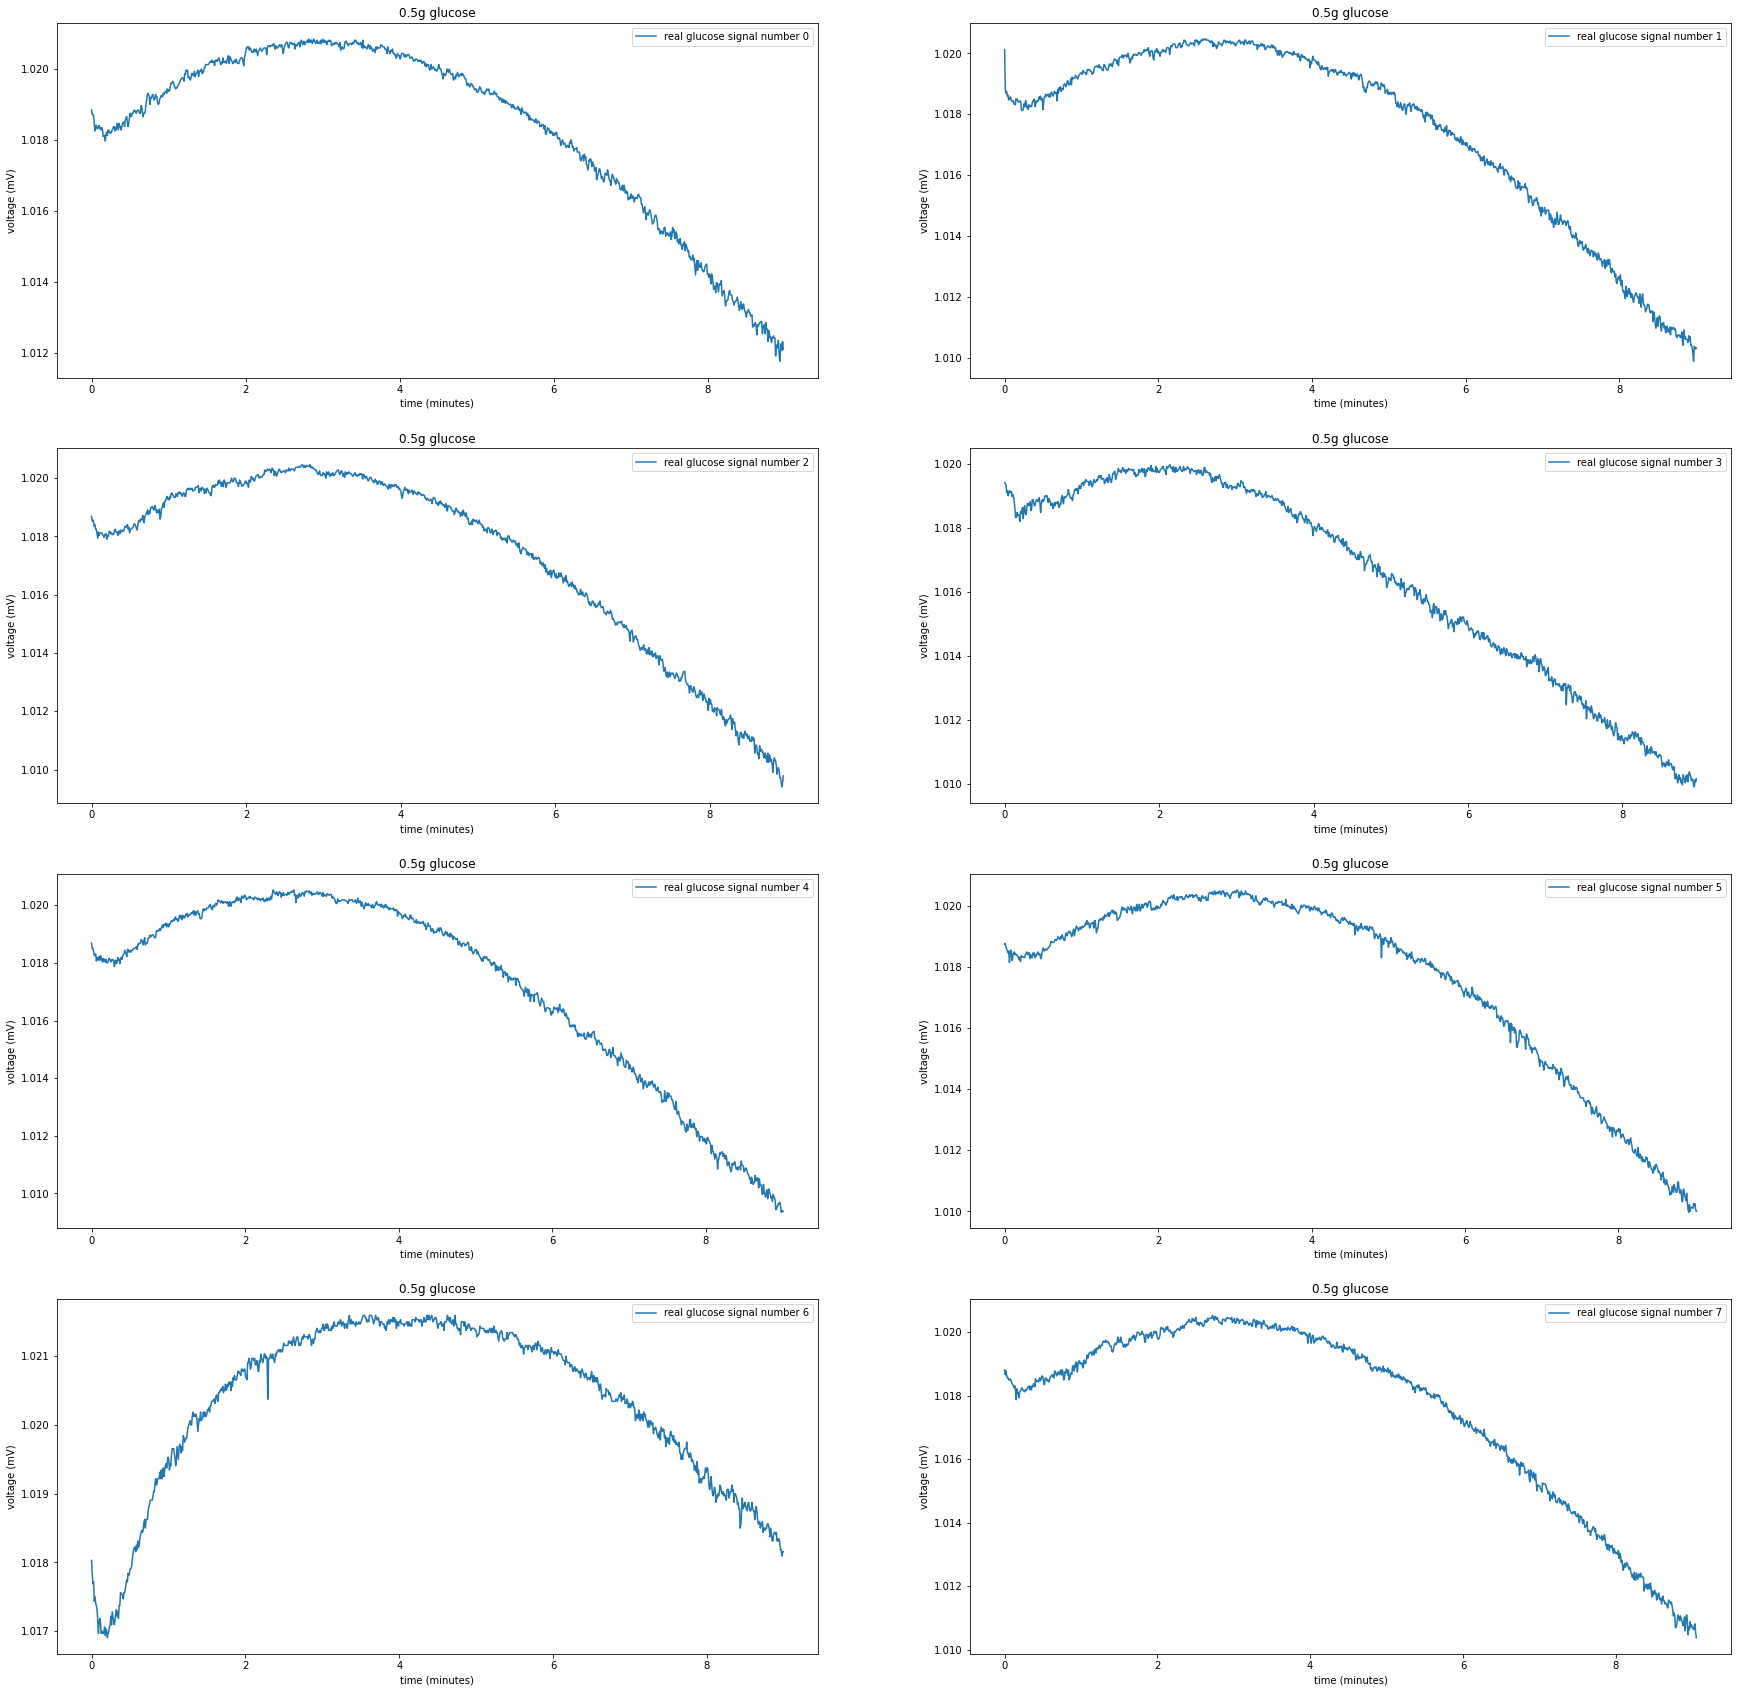

In [4]:
# read the data
def plot_glucose_ts(glucose_timeseries, title=''):
    figure, axises = plt.subplots(4, 2, figsize=(30, 30))

    for counter, ax in enumerate(axises.flatten()):

        glucose_ts = glucose_timeseries[counter]
        ax.plot(
            glucose_ts.points_in_time,
            glucose_ts.voltages,
            label='real glucose signal number %s' % (counter)
        )

        ax.set_xlabel('time (minutes)')
        ax.set_ylabel('voltage (mV)')
        ax.set_title(title)
        ax.legend()
plot_glucose_ts(glucose_series_0_5g, title='0.5g glucose')

These graphs for $0.5g$ of glucose do not look like a process that converges to an equilibrium mode. But the next graphs for $1g$ of glucose looks much better.

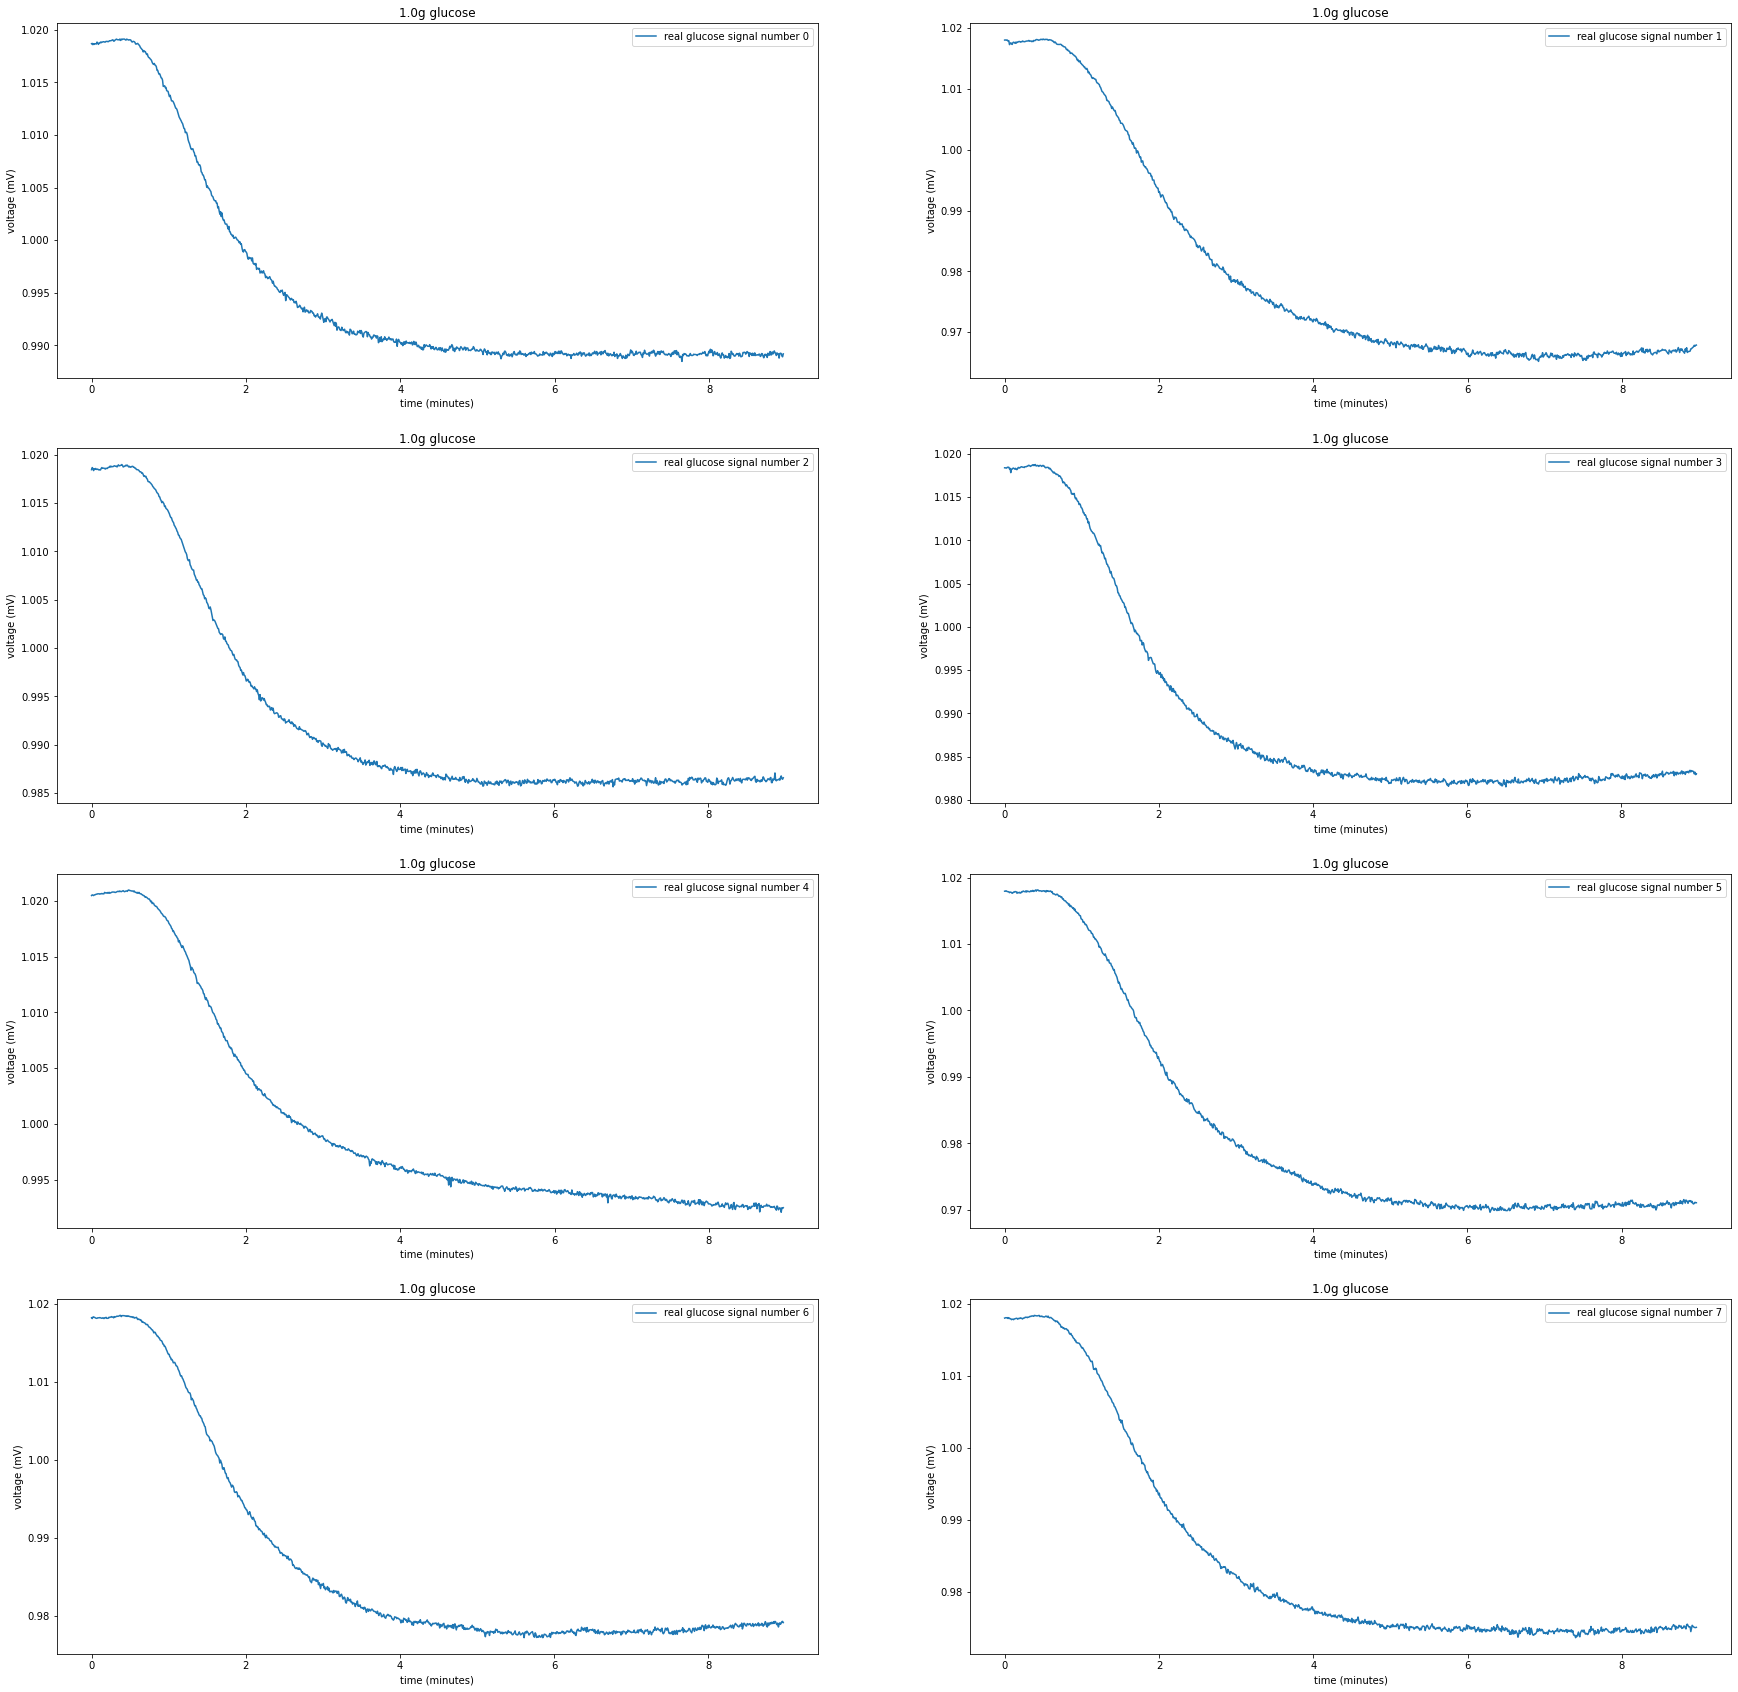

In [6]:
plot_glucose_ts(glucose_series_1_0g, title='1.0g glucose')

In [7]:
import multiprocessing

def train_single_model(args):
    model, glucose_series = args
    return model.fit(
        glucose_series.points_in_time,
        glucose_series.voltages
    )


def train_models(all_glucose_ts, priors=None, model_type=None):
    model_type = model_type or glucose_ts.models.LogisticDecrease
    arguments = zip([model_type(gaussian_priors=priors)] * len(all_glucose_ts), all_glucose_ts)
    with multiprocessing.Pool(8) as pool:
        return [model for model in pool.map(train_single_model, arguments)]

# TODO: this training process is broken. It does not converge to a good paramter setting
logistic_growth_models_1g = train_models(glucose_series_1_0g, model_type=glucose_ts.models.LogisticDecrease)

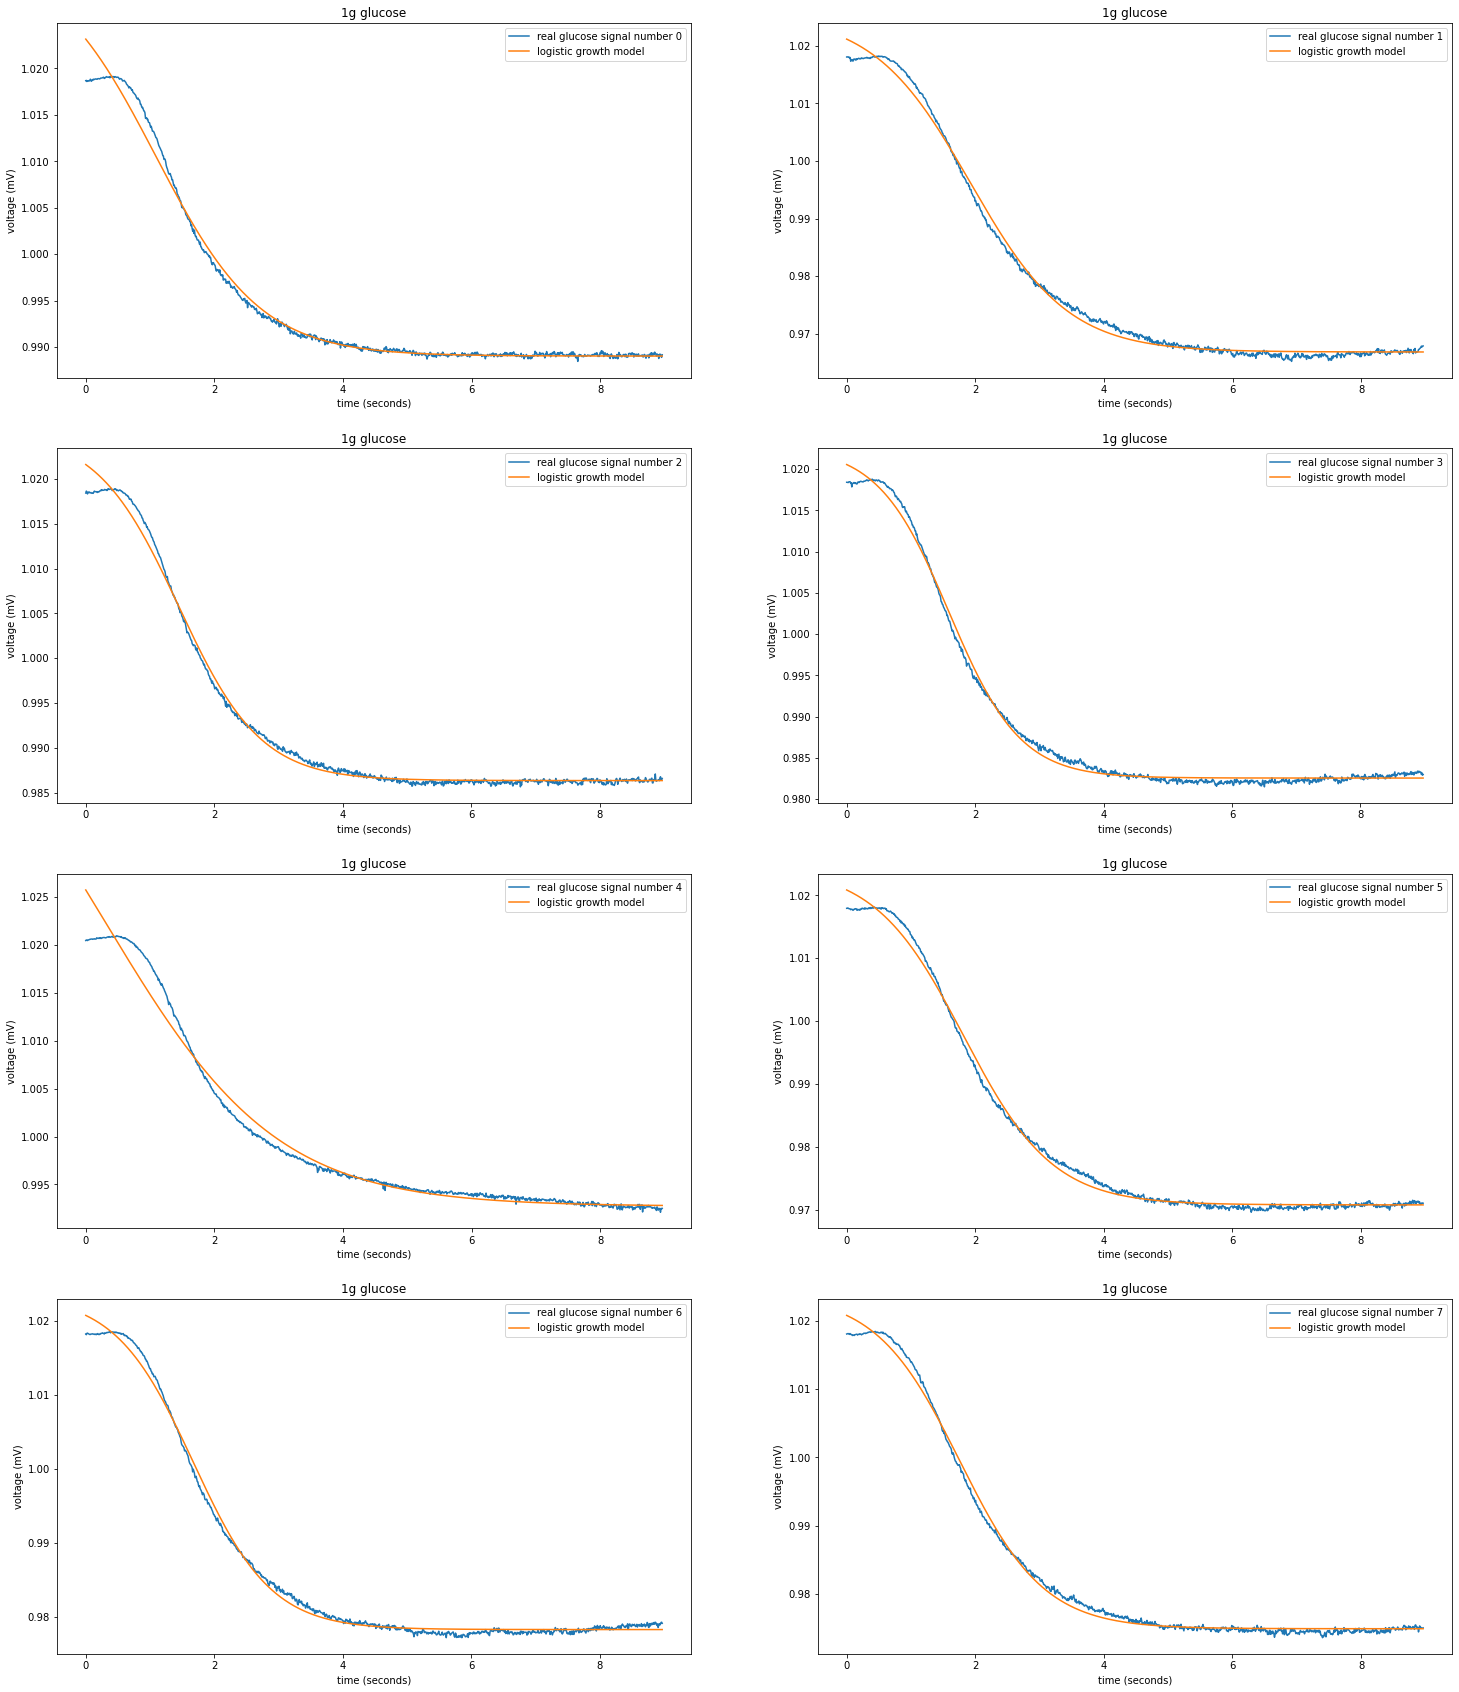

In [8]:

def plot_glucose_vs_model(glucose_timeseries, models, training_cutoff=None):
    figure, axises = plt.subplots(4, 2, figsize=(25, 30))

    for counter, ax in enumerate(axises.flatten()):

        model = models[counter]
        glucose_ts = glucose_timeseries[counter]
        ax.plot(
            glucose_ts.points_in_time,
            glucose_ts.voltages,
            label='real glucose signal number %s' % (counter)
        )

#         time = np.array(list(np.arange(-200, 0)) + list(glucose_ts.points_in_time.flatten()))
        time = glucose_ts.points_in_time
        # vstack in numpy
        ax.plot(
            time,
            model.predict(time),
            label='logistic growth model',
        )
#         derivative_ax = ax.twinx()

#         derivative_ax.plot(
#             time,
#             model.derivative(time),
#             label='derivative of the model',
#         )

        
        if training_cutoff:
            ax.axvline(x=training_cutoff, label='training cutoff', linestyle='--')

        ax.set_xlabel('time (seconds)')
        ax.set_ylabel('voltage (mV)')
        ax.set_title('1g glucose')
        ax.legend()
        
plot_glucose_vs_model(glucose_series_1_0g, logistic_growth_models_1g)

The fit for these models is quite ok, so let us check how it works, when we cut of the glucose timeseries earlier and try to fit the negative logistics growth model to it. 

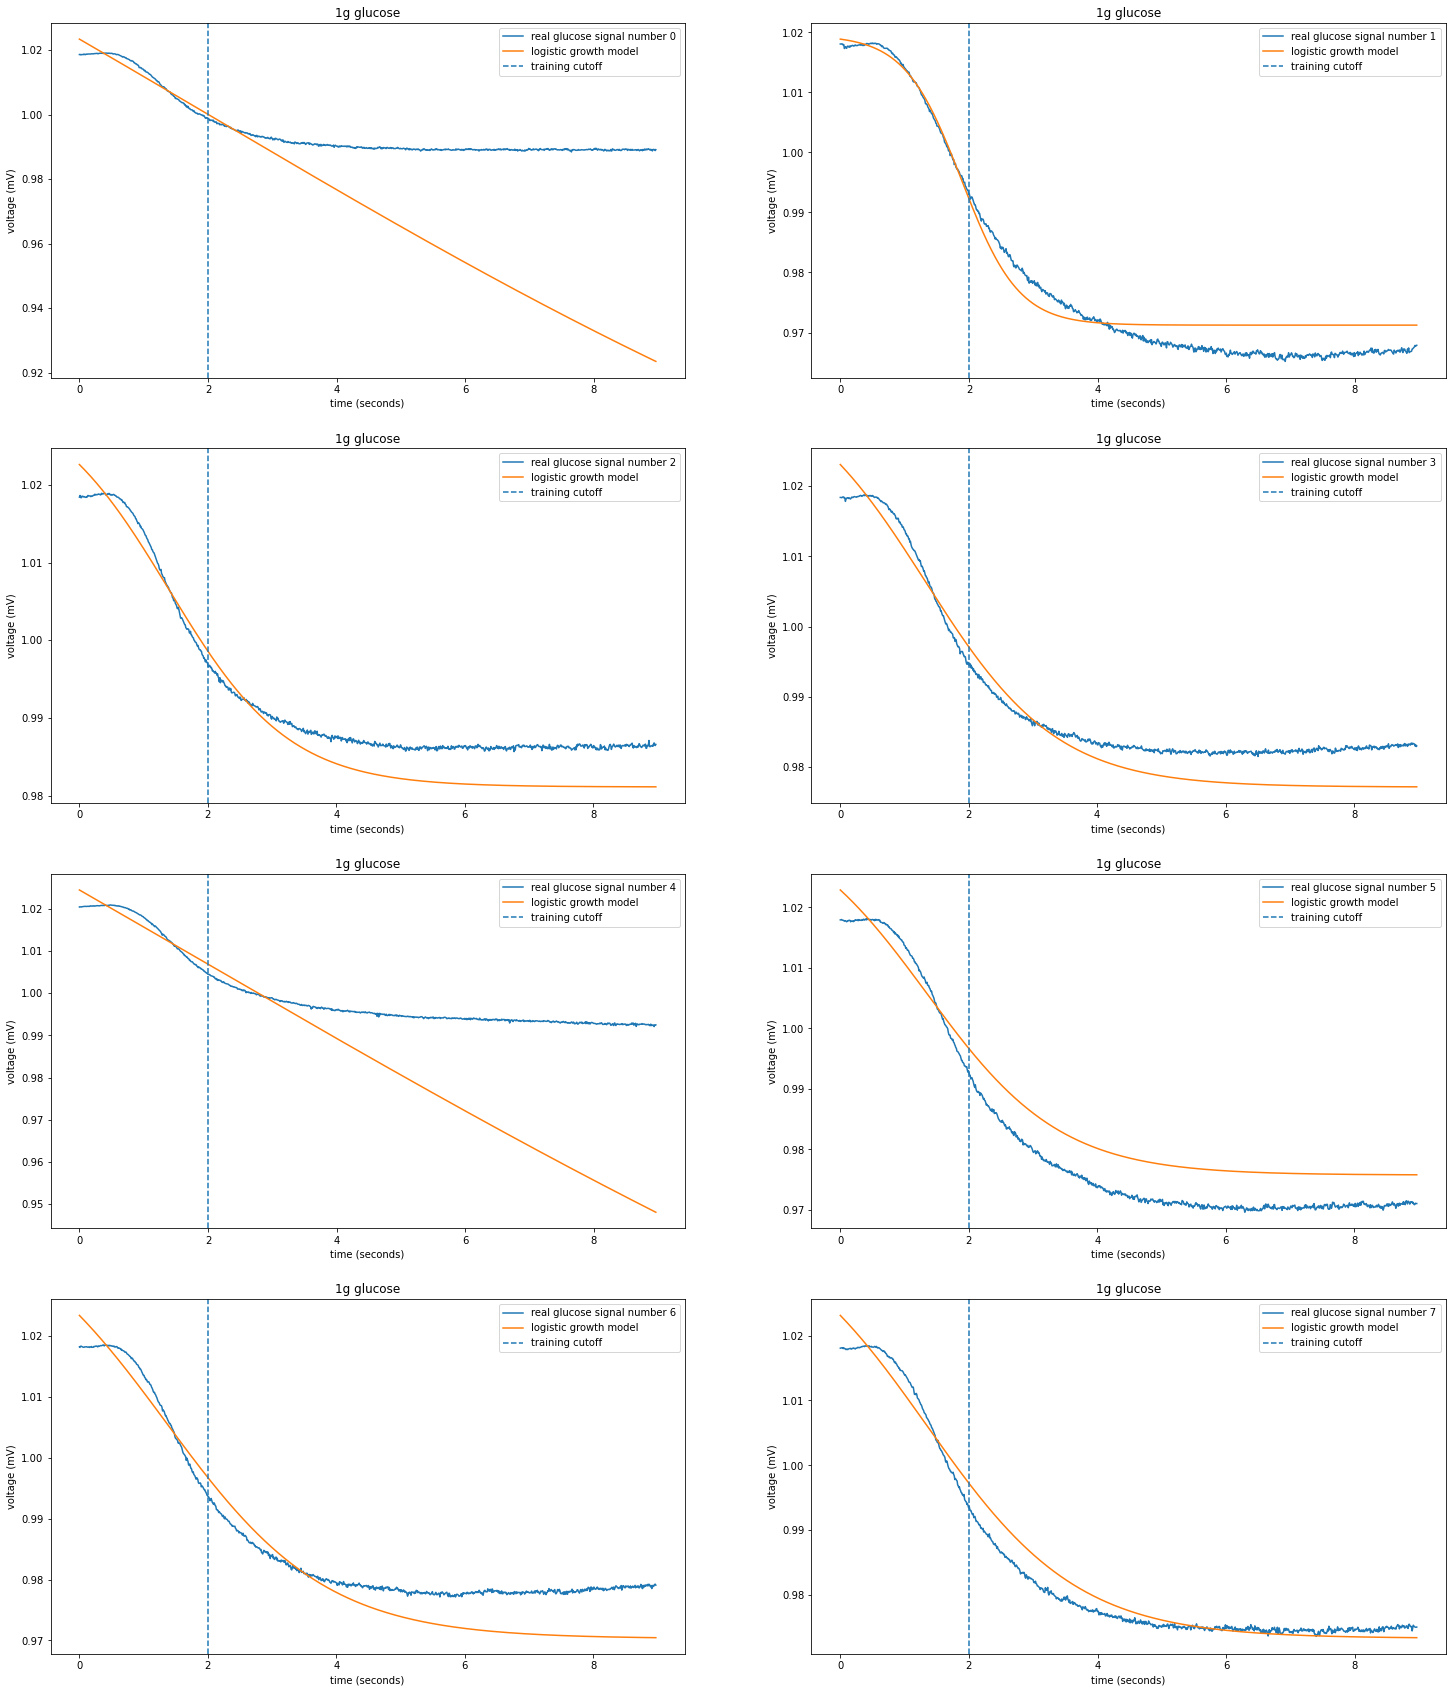

In [9]:
cut_off_time = 2
cutted_series = [glucose_ts.data.cut_timeseries(ts, cut_off_time) for ts in glucose_series_1_0g]

cutted_models = train_models(cutted_series)

plot_glucose_vs_model(glucose_series_1_0g, cutted_models, cut_off_time)
# cutted_series[0]

## Exponential Decay Model

Therefore let's try to have a look how different models look like. Therefore we will start with the an exponential decay approach. In particular we have two slightly different approaches here. The first one is the classic approach where the decay starts at time $t=0$ being the steepest. Moreover we can introduce a location parameter to the exponential decay function such that the decay starts later. 

### Classic Exponential Decay

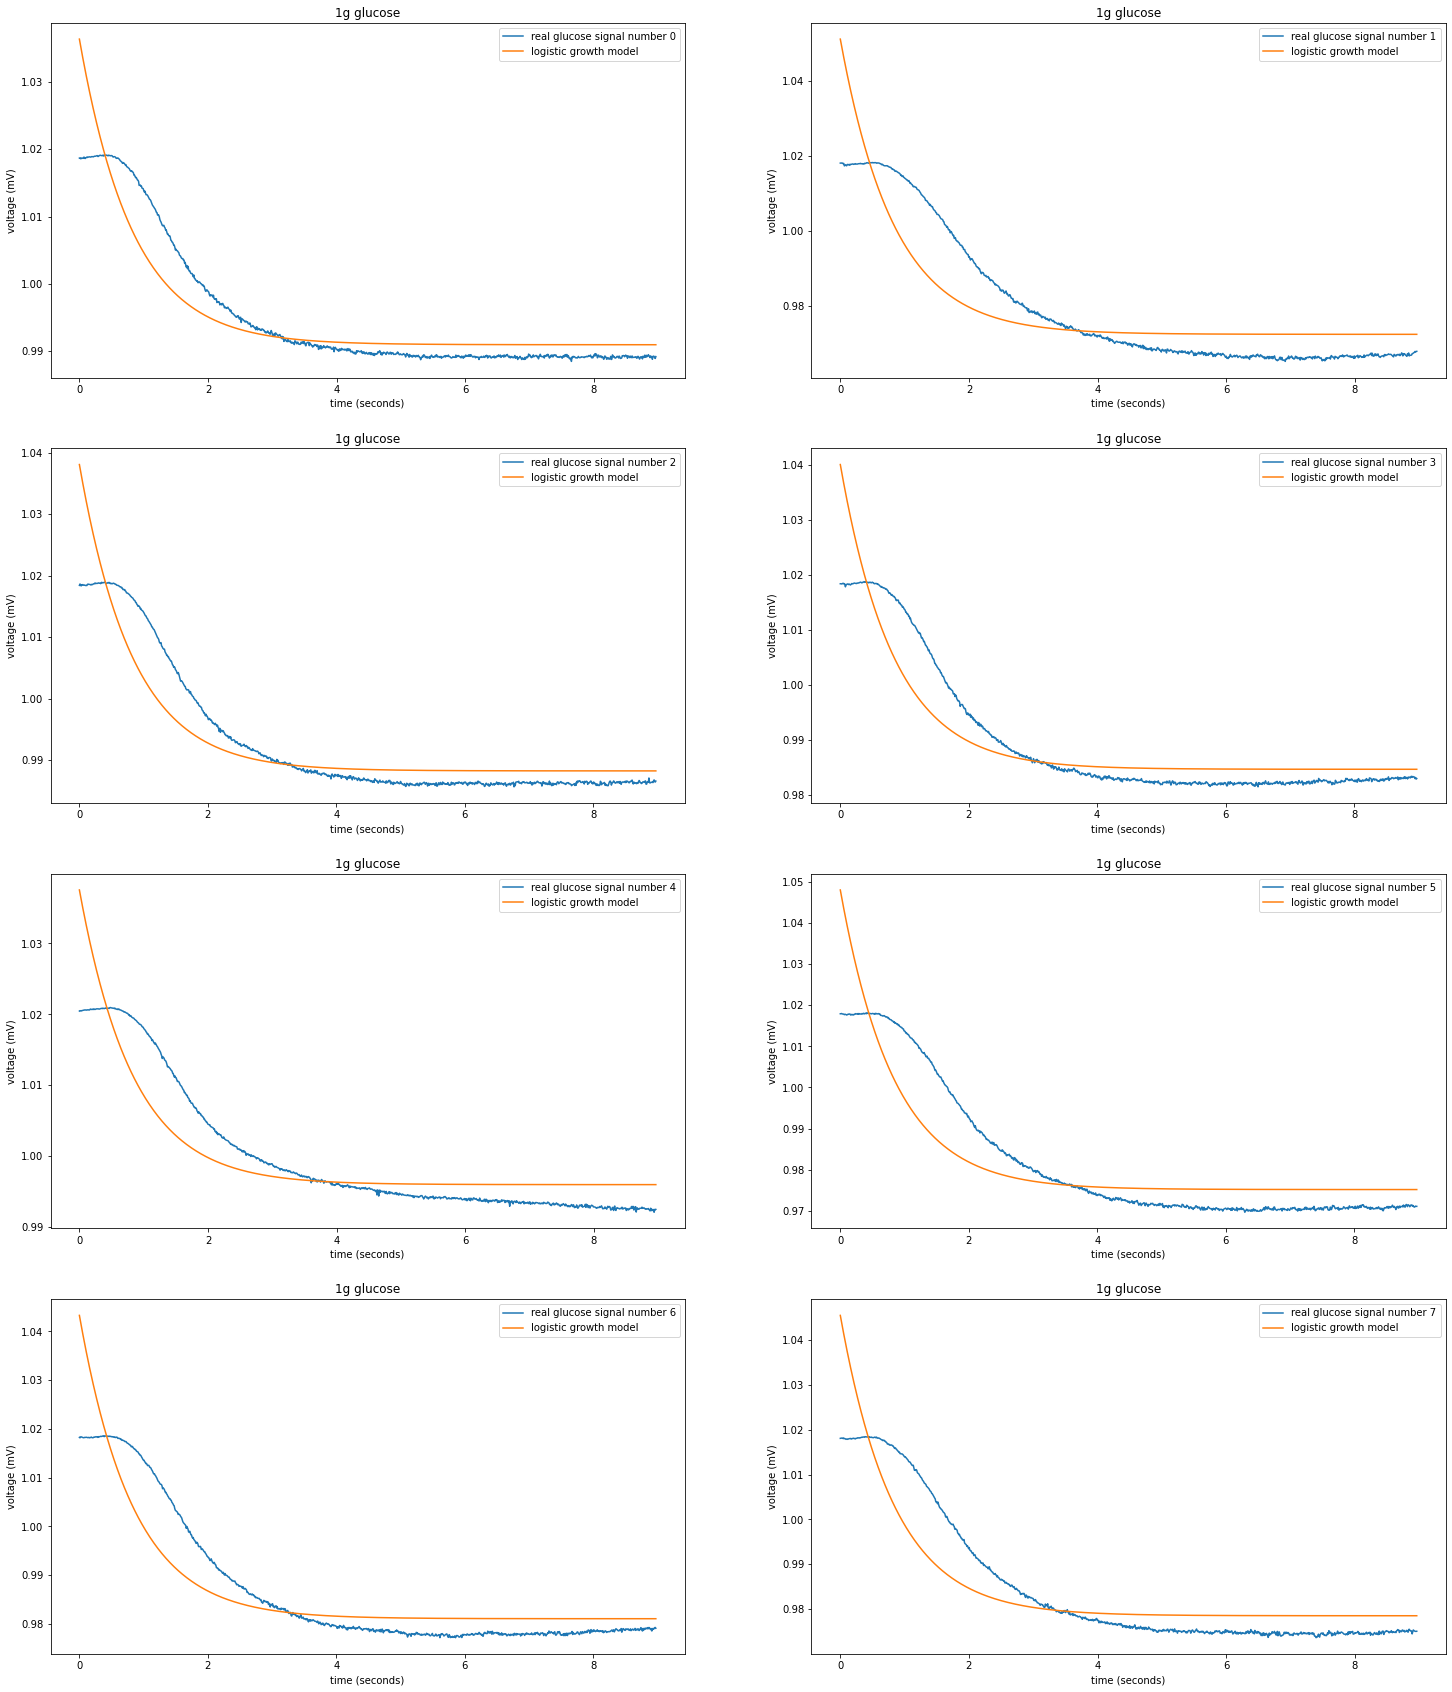

In [10]:
cut_off_time = None
cutted_series = [glucose_ts.data.cut_timeseries(ts, cut_off_time) for ts in glucose_series_1_0g]

cutted_models = train_models(cutted_series, model_type=glucose_ts.models.ExponentialDecay)

plot_glucose_vs_model(glucose_series_1_0g, cutted_models, cut_off_time)




As you can see this model works very poorly. Therefore let's try the version with the delayed exponential decay.

### Generalized Logistic Growth Model

[ 1.01940500e+00  9.86321126e-01  1.41613469e+00  1.95163957e-04
 -4.65357618e+00]
[ 1.01907673e+00  9.66564457e-01  1.08487720e+00  3.54708762e-04
 -5.59360600e+00]
[ 1.02201339e+00  9.93541339e-01  1.11397463e+00  2.64836365e-04
 -5.91141117e+00]
[ 1.01968599e+00  9.89286795e-01  1.41732611e+00  1.89226924e-04
 -4.71539266e+00]
[ 1.01904751e+00  9.82438597e-01  1.45957775e+00  2.29253415e-04
 -4.32350426e+00]
[ 1.01898686e+00  9.74753865e-01  1.24535321e+00  1.88065296e-04
 -5.31534238e+00]
[ 1.01904055e+00  9.78126253e-01  1.34930302e+00  2.63698875e-04
 -4.61346185e+00]
[ 1.01886940e+00  9.70596045e-01  1.18469291e+00  2.42619088e-04
 -5.39683649e+00]


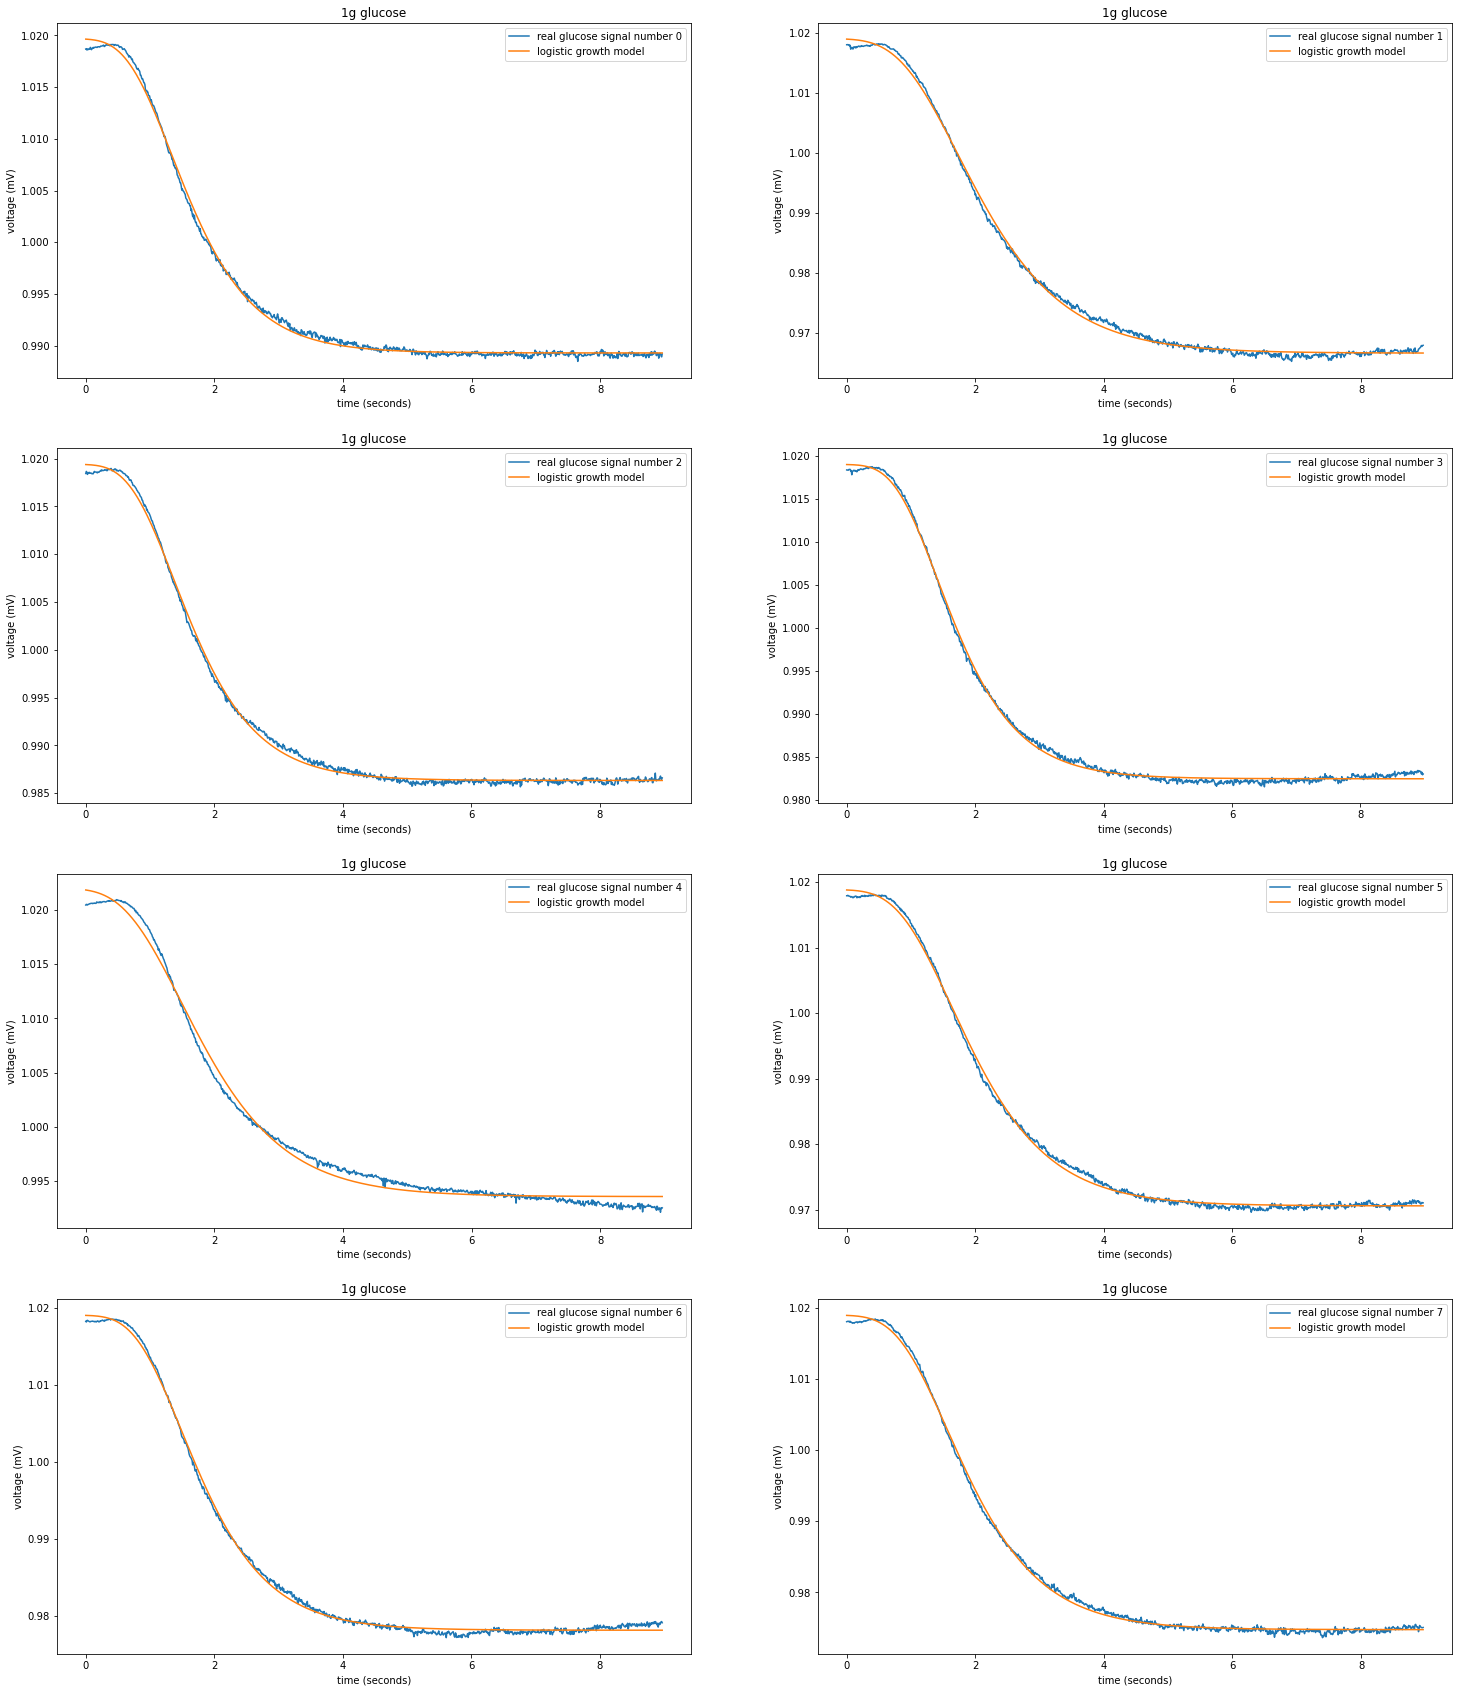

In [11]:
cut_off_time = None
cutted_series = [glucose_ts.data.cut_timeseries(ts, cut_off_time) for ts in glucose_series_1_0g]

cutted_models = train_models(cutted_series, model_type=glucose_ts.models.GeneralizedLogistic)

plot_glucose_vs_model(glucose_series_1_0g, cutted_models, cut_off_time)


The last model looks quite promising. So let's take a look whether we can make an earlier cutoff for this type of model.

[ 1.02119595e+00  9.95286689e-01  1.41018917e+00  2.04757133e-04
 -4.54825182e+00][ 1.01856161e+00  9.68324923e-01  1.19813690e+00  1.81055323e-04
 -5.48048827e+00]

[ 1.01947541e+00  9.89827564e-01  1.50924866e+00  1.49634773e-04
 -4.50670888e+00]
[ 1.01924050e+00  9.86794539e-01  1.48647223e+00  1.62182126e-04
 -4.49709616e+00]
[ 1.01897055e+00  9.82717288e-01  1.49442847e+00  1.68207779e-04
 -4.40018971e+00]
[ 1.01860143e+00  9.71523833e-01  1.25434194e+00  1.97535008e-04
 -5.18019883e+00]
[ 1.01895461e+00  9.78471072e-01  1.38179838e+00  1.45015902e-04
 -4.90719188e+00]
[ 1.01874998e+00  9.75510949e-01  1.31460814e+00  1.47140255e-04
 -5.14643416e+00]


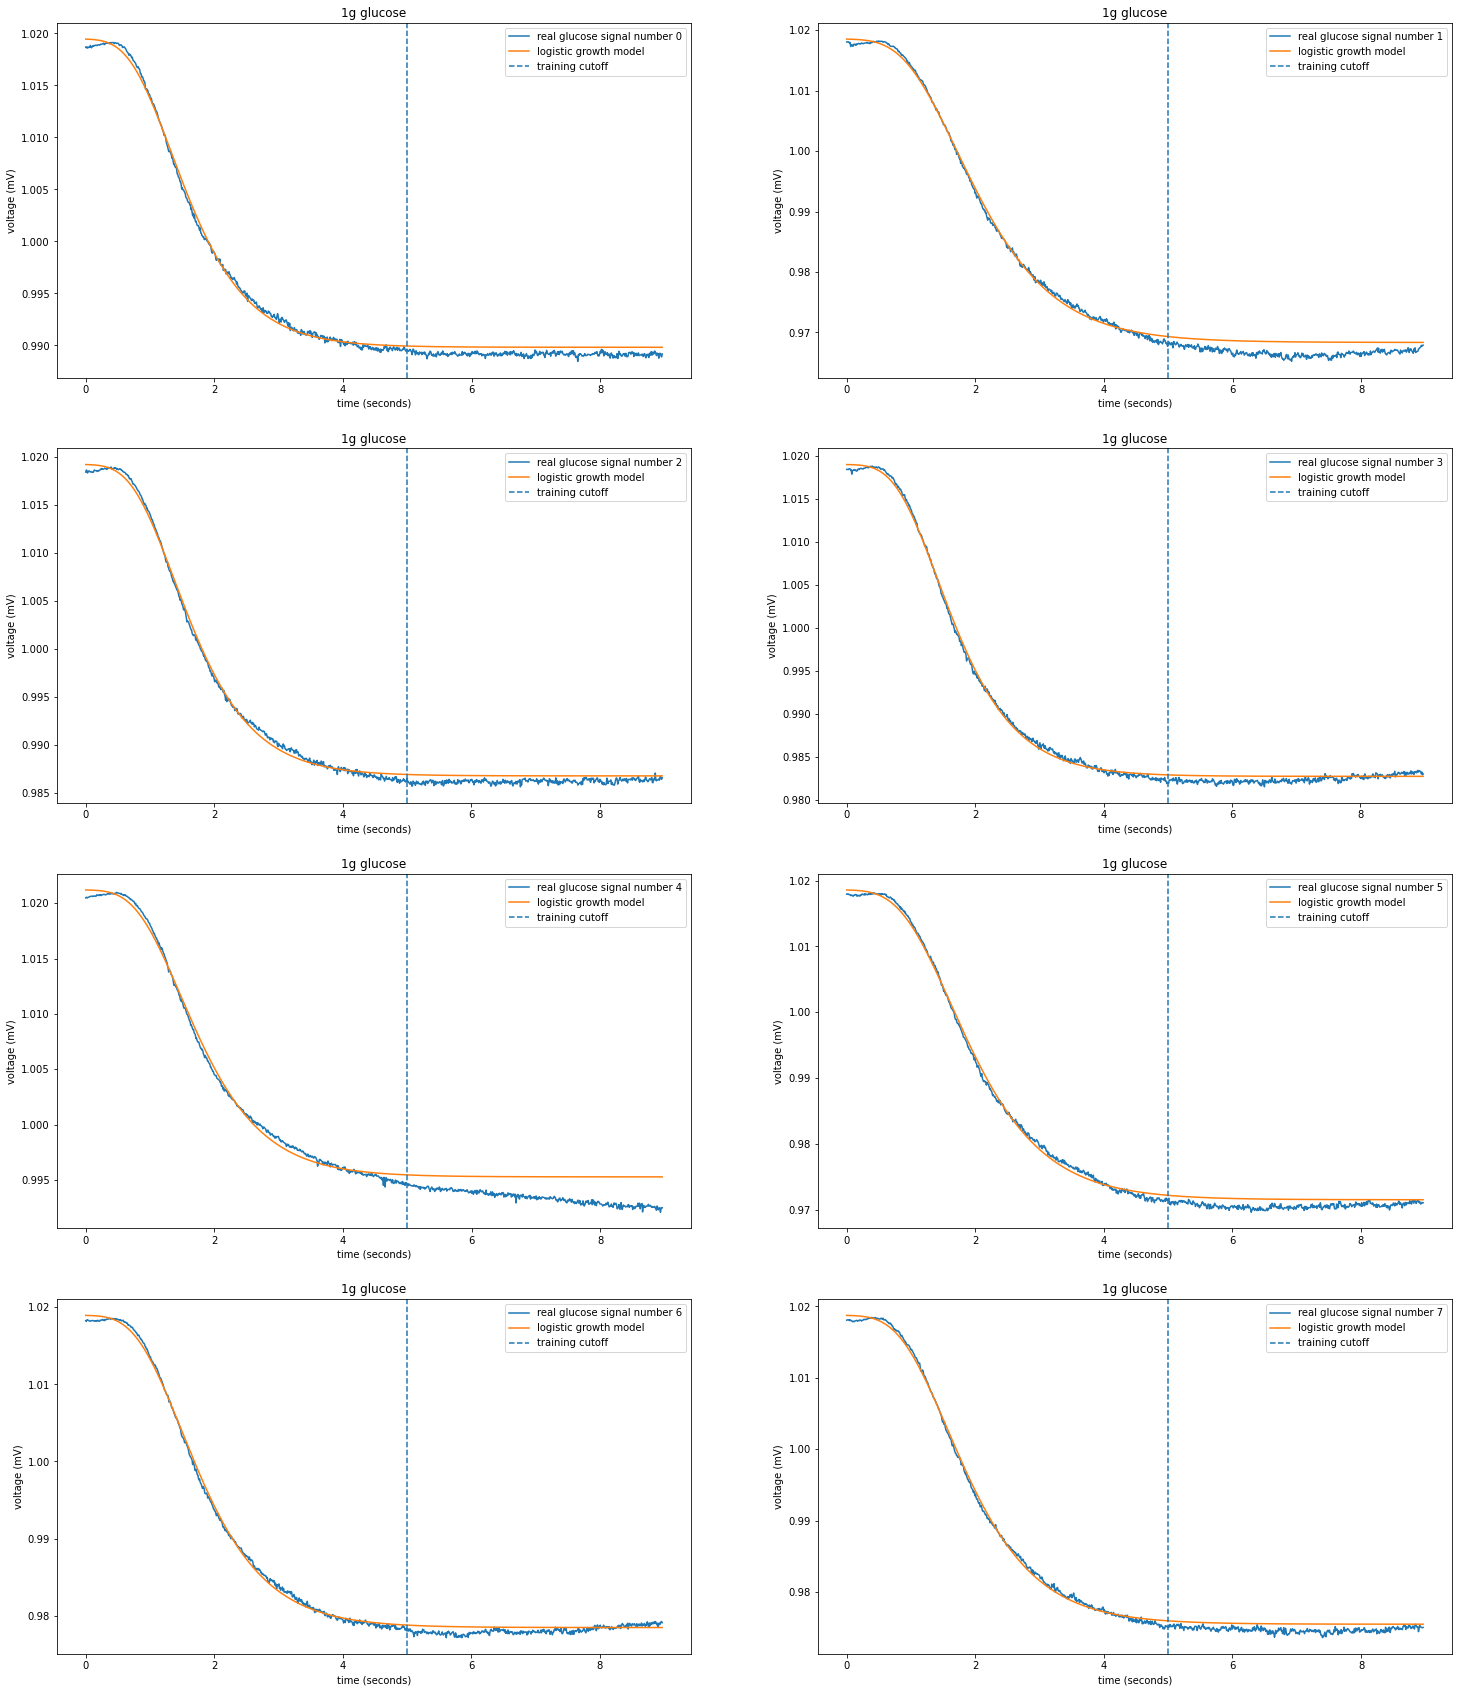

In [12]:
cut_off_time = 5
cutted_series = [glucose_ts.data.cut_timeseries(ts, cut_off_time) for ts in glucose_series_1_0g]

cutted_models = train_models(cutted_series, model_type=glucose_ts.models.GeneralizedLogistic)

plot_glucose_vs_model(glucose_series_1_0g, cutted_models, cut_off_time)


[ 1.01901789e+00  9.94064709e-01  2.02905026e+00  3.20404071e-04
 -2.72527874e+00]
[ 1.01804201e+00  9.76707556e-01  1.53004974e+00  4.62021761e-04
 -3.44314417e+00]
[ 1.01877953e+00  9.91177195e-01  1.95031216e+00  2.68695581e-04
 -2.92638655e+00]
[ 1.01859107e+00  9.86005406e-01  1.81212434e+00  3.86542596e-04
 -2.97892674e+00]
[ 1.02079552e+00  9.98853264e-01  1.90778860e+00  3.47433122e-04
 -2.78977145e+00]
[ 1.01802454e+00  9.77393611e-01  1.57824067e+00  4.36498393e-04
 -3.37458533e+00]
[ 1.01845474e+00  9.83660973e-01  1.76811438e+00  3.37718653e-04
 -3.12075119e+00]
[ 1.01825843e+00  9.81381134e-01  1.66630155e+00  4.72652161e-04
 -3.12902224e+00]


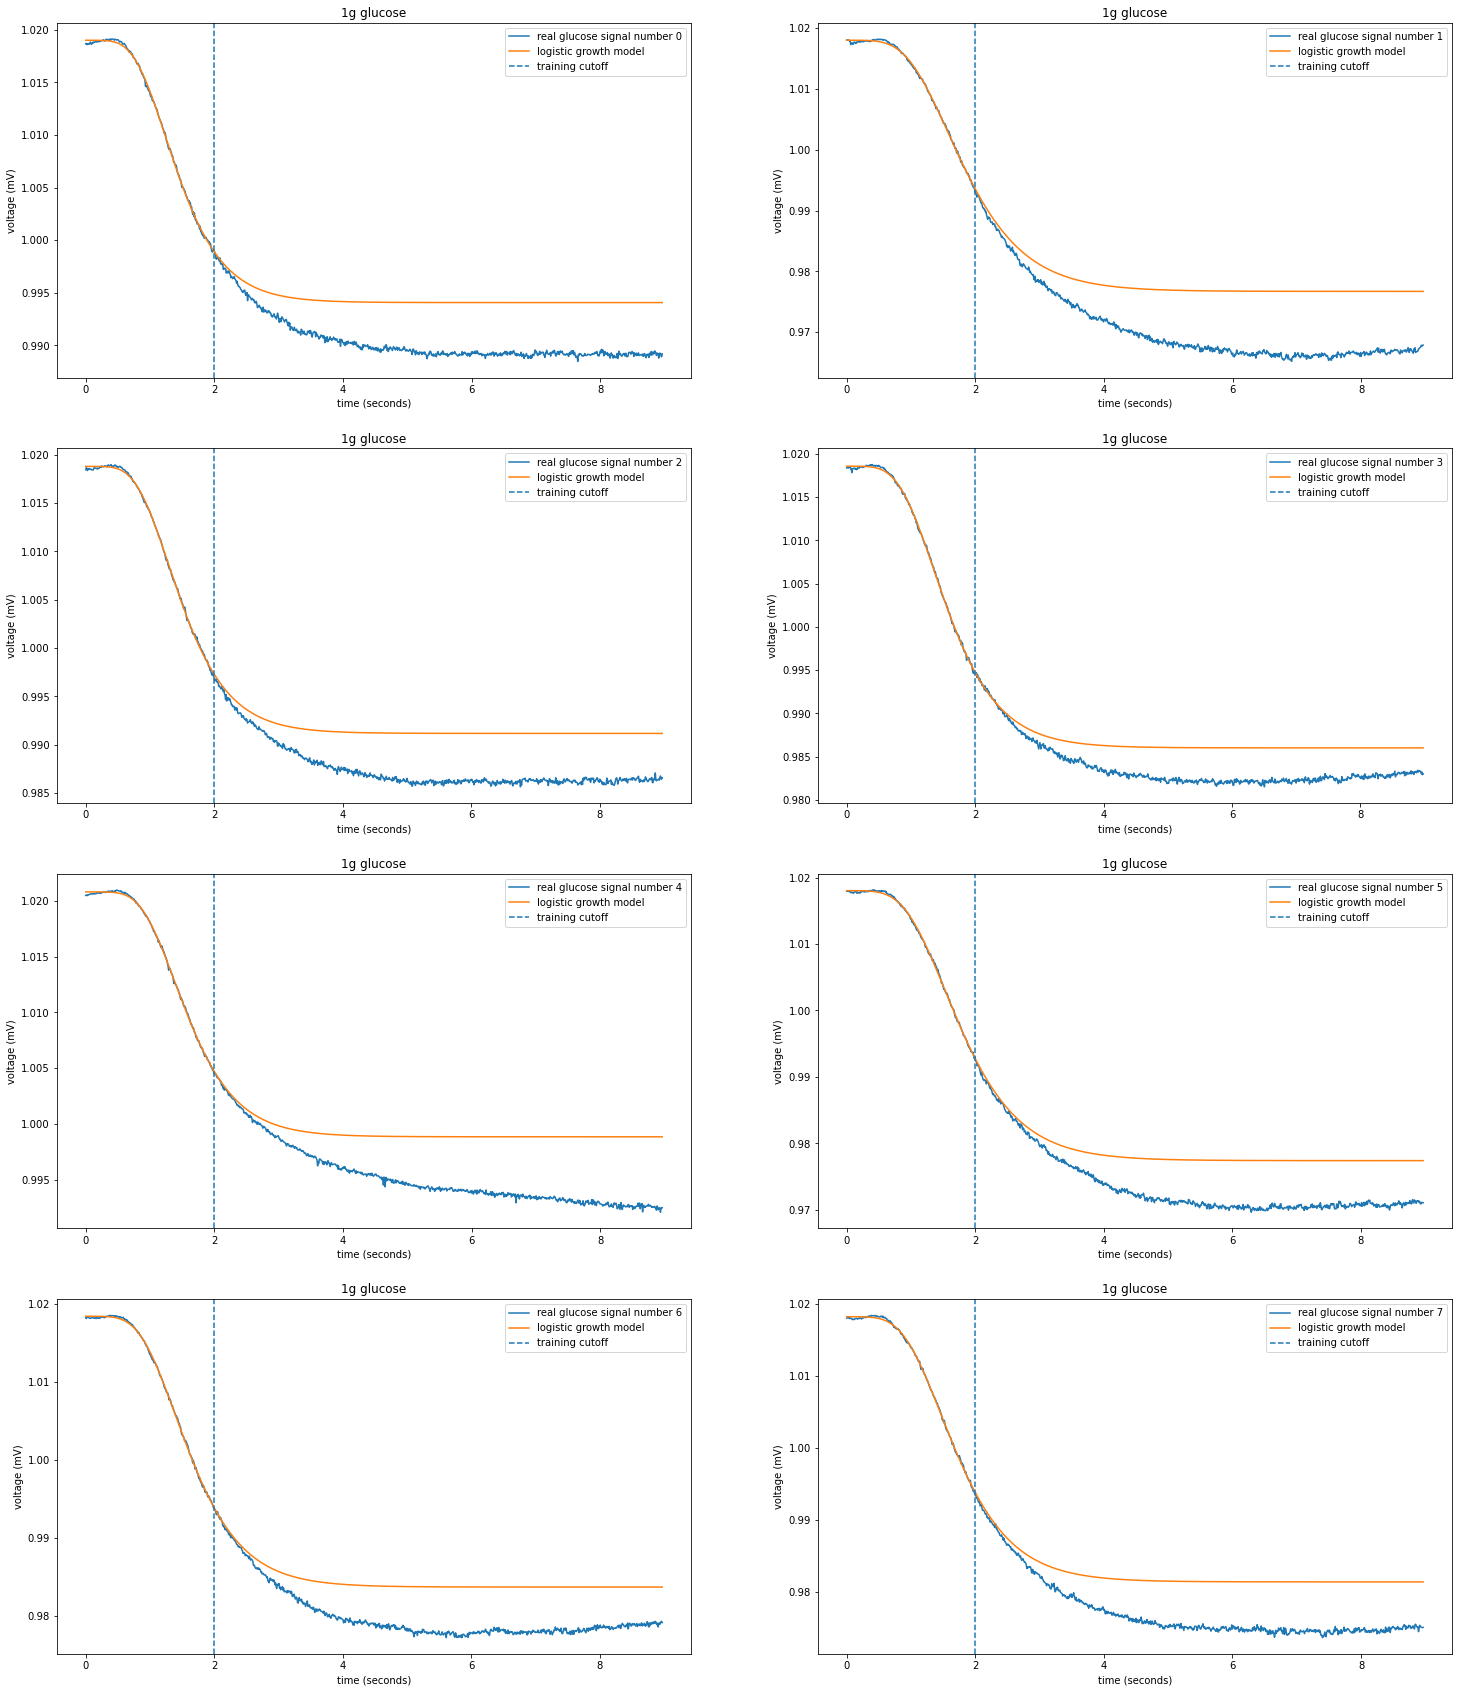

In [13]:
cut_off_time = 2.
cutted_series = [glucose_ts.data.cut_timeseries(ts, cut_off_time) for ts in glucose_series_1_0g]

cutted_models = [
    glucose_ts.models.GeneralizedLogistic().fit(
        glucose_series.points_in_time,
        glucose_series.voltages,
    ) for glucose_series in cutted_series
]

plot_glucose_vs_model(glucose_series_1_0g, cutted_models, cut_off_time)


[ 1.99908004e+01  9.58721798e+00  8.36378018e+00  5.30328023e-07
 -1.07325058e+00]


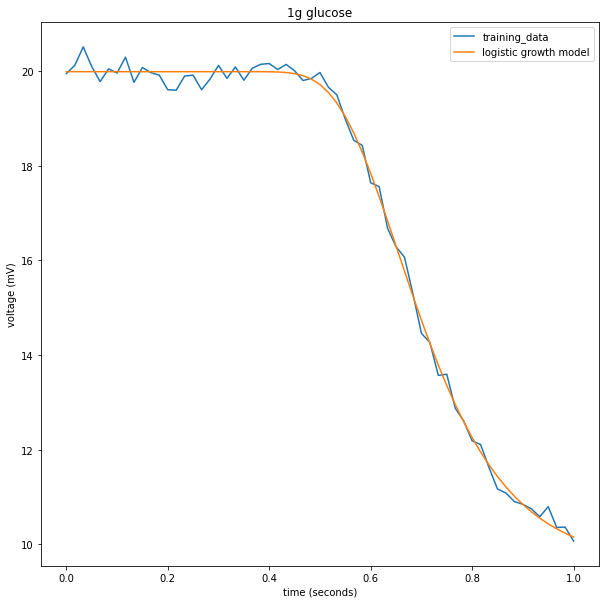

In [14]:
from glucose_ts.models.generalized_logistics_curve import *

# fit one Generalized Logistic model

points_in_time = np.linspace(0, 60, 61) / 60
target_parameter = GLParameter(
    A=20,
    K=10,
    B=10,
    nue=0.2,
    M=0.5,
)
labels = generalized_logistics_function(
    points_in_time,
    *target_parameter
) + np.random.randn(*points_in_time.shape) * .2

# when
model = GeneralizedLogistic().fit(points_in_time.reshape(-1, 1), labels)




figure, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.plot(
    points_in_time,
    labels,
    label='training_data',
)

ax.plot(
    points_in_time,
    model.predict(points_in_time),
    label='logistic growth model',
)


ax.set_xlabel('time (seconds)')
ax.set_ylabel('voltage (mV)')
ax.set_title('1g glucose')
ax.legend()


# parameter priors

Now we want to get the prior distributions for the parameters of the generalized logistic function

NameError: name 'NLGParameter' is not defined

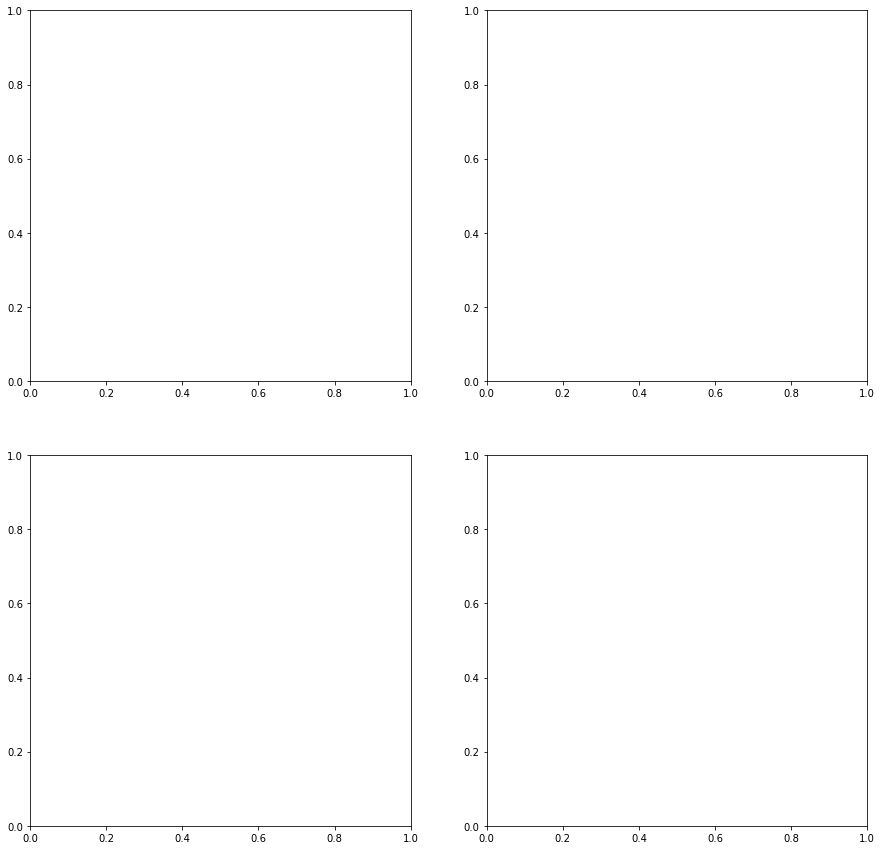

In [15]:
# we take the full time series models plot the parameters


figure, axises = plt.subplots(2, 2, figsize=(15, 15))

nlg_parameter = NLGParameter(*zip(*[model.nlg_parameter for model in logistic_growth_models.values()]))

for ax, (parameter, values) in zip(axises.flatten(), nlg_parameter._asdict().items()):

    sns.histplot(values, ax=ax, kde=True)
    ax.set_xlabel(parameter)
    ax.set_ylabel('counts')
    ax.set_title('%s distribution' % parameter)

    
    

Now we would like to get the prior distribution for these four parameters.

In [ ]:
gaussian_priors = [for parameter_values in nlg_parameter]

gaussian_priors

In [ ]:
cut_off = 200

cutted_models = train_models(
    {idx: cut_timeseries(ts, cut_off) for idx, ts in glucose_ts_1g.items()},
    gaussian_priors
)

plot_glucose_vs_model(glucose_ts_1g, cutted_models, cut_off)


In [ ]:
idmax_df1 = df_1_0to1000['Value'].idxmax()
idmax_df2 = df_2_0to1000['Value'].idxmax()
idmax_df3 = df_3_0to1000['Value'].idxmax()
idmax_df4 = df_4_0to1000['Value'].idxmax()
idmax_df5 = df_5_0to1000['Value'].idxmax()
idmax_df6 = df_6_0to1000['Value'].idxmax()
idmax_df7 = df_7_0to1000['Value'].idxmax()
idmax_df8 = df_8_0to1000['Value'].idxmax()

print(idmax_df1)
print(idmax_df2)
print(idmax_df3)
print(idmax_df4)
print(idmax_df5)
print(idmax_df6)
print(idmax_df7)
print(idmax_df8)

fig = plt.figure(figsize=(12, 7))
plt.plot(df_1_0to1000['deltaTime'][idmax_df1:], df_1_0to1000['Value'][idmax_df1:], '-o', label='1', markersize=1)
plt.plot(df_2_0to1000['deltaTime'][idmax_df2:], df_2_0to1000['Value'][idmax_df2:], '-o', label='2', markersize=1)
plt.plot(df_3_0to1000['deltaTime'][idmax_df3:], df_3_0to1000['Value'][idmax_df3:], '-o', label='3', markersize=1)
plt.plot(df_4_0to1000['deltaTime'][idmax_df4:], df_4_0to1000['Value'][idmax_df4:], '-o', label='4', markersize=1)
plt.plot(df_5_0to1000['deltaTime'][idmax_df5:], df_5_0to1000['Value'][idmax_df5:], '-o', label='5', markersize=1)
plt.plot(df_6_0to1000['deltaTime'][idmax_df6:], df_6_0to1000['Value'][idmax_df6:], '-o', label='6', markersize=1)
plt.plot(df_7_0to1000['deltaTime'][idmax_df7:], df_7_0to1000['Value'][idmax_df7:], '-o', label='7', markersize=1)
plt.plot(df_8_0to1000['deltaTime'][idmax_df8:], df_8_0to1000['Value'][idmax_df8:], '-o', label='8', markersize=1)

plt.legend()
plt.xlabel('deltaTime'); plt.ylabel('value'); plt.grid(True)

In [ ]:
import numpy as np 
  
from matplotlib import pyplot as plt 

x_df_1_0to1000 = np.array(df_1_0to1000['deltaTime'][idmax_df1:], dtype=int)
y_df_1_0to1000 = np.array(df_1_0to1000['Value'][idmax_df1:])

x_df_2_0to1000 = np.array(df_2_0to1000['deltaTime'][idmax_df2:], dtype=int)
y_df_2_0to1000 = np.array(df_2_0to1000['Value'][idmax_df2:])

x_df_3_0to1000 = np.array(df_3_0to1000['deltaTime'][idmax_df3:], dtype=int)
y_df_3_0to1000 = np.array(df_3_0to1000['Value'][idmax_df3:])

x_df_4_0to1000 = np.array(df_4_0to1000['deltaTime'][idmax_df4:], dtype=int)
y_df_4_0to1000 = np.array(df_4_0to1000['Value'][idmax_df4:])

x_df_5_0to1000 = np.array(df_5_0to1000['deltaTime'][idmax_df5:], dtype=int)
y_df_5_0to1000 = np.array(df_5_0to1000['Value'][idmax_df5:])

x_df_6_0to1000 = np.array(df_6_0to1000['deltaTime'][idmax_df6:], dtype=int)
y_df_6_0to1000 = np.array(df_6_0to1000['Value'][idmax_df6:])

x_df_7_0to1000 = np.array(df_7_0to1000['deltaTime'][idmax_df7:], dtype=int)
y_df_7_0to1000 = np.array(df_7_0to1000['Value'][idmax_df7:])

x_df_8_0to1000 = np.array(df_8_0to1000['deltaTime'][idmax_df8:], dtype=int)
y_df_8_0to1000 = np.array(df_8_0to1000['Value'][idmax_df8:])
import scipy.signal

yhat1 = scipy.signal.savgol_filter(y_df_1_0to1000, 51, 3) # window size 51, polynomial order 3
yhat2 = scipy.signal.savgol_filter(y_df_2_0to1000, 51, 3) # window size 51, polynomial order 3
yhat3 = scipy.signal.savgol_filter(y_df_3_0to1000, 51, 3) # window size 51, polynomial order 3
yhat4 = scipy.signal.savgol_filter(y_df_4_0to1000, 51, 3) # window size 51, polynomial order 3
yhat5 = scipy.signal.savgol_filter(y_df_5_0to1000, 51, 3) # window size 51, polynomial order 3
yhat6 = scipy.signal.savgol_filter(y_df_6_0to1000, 51, 3) # window size 51, polynomial order 3
yhat7 = scipy.signal.savgol_filter(y_df_7_0to1000, 51, 3) # window size 51, polynomial order 3
yhat8 = scipy.signal.savgol_filter(y_df_8_0to1000, 51, 3) # window size 51, polynomial order 3

fig = plt.figure(figsize=(12, 7))
plt.plot(df_1_0to1000['deltaTime'][idmax_df1:], yhat1, '-o', label='1', markersize=1)
plt.plot(df_2_0to1000['deltaTime'][idmax_df2:], yhat2, '-o', label='2', markersize=1)
plt.plot(df_3_0to1000['deltaTime'][idmax_df3:], yhat3, '-o', label='3', markersize=1)
plt.plot(df_4_0to1000['deltaTime'][idmax_df4:], yhat4, '-o', label='4', markersize=1)
#plt.plot(df_5_0to1000['deltaTime'][idmax_df5:], yhat5, '-o', label='5', markersize=1)
plt.plot(df_6_0to1000['deltaTime'][idmax_df6:], yhat6, '-o', label='6', markersize=1)
#plt.plot(df_7_0to1000['deltaTime'][idmax_df7:], yhat7, '-o', label='7', markersize=1)
#plt.plot(df_8_0to1000['deltaTime'][idmax_df8:], yhat8, '-o', label='8', markersize=1)

plt.legend()
plt.xlabel('deltaTime'); plt.ylabel('value'); plt.grid(True)

## Negative exponential growth

It turns out that the logistics growth function does not fit the curves that well, we try a different growth model. The idea is to neglect accelerated part of the growth in the beginning. Therefore we assume a growth model that looks like this:

$ x(t) = x_0 - \delta \exp( \frac{t} {\tau}) $

Here we just have three parameters

 * $x_0$ 
 * $\delta$
 * $\tau$
 
that need to be determined. We assume that the decay is steapest in the beginning which might be problematic. But let's see.

Getting the derivative
* real voltage signal
* differenciate the approximated signal with respect to time

## analytical derivative of the model

Pure model function 
```
v(t) = max_value - ( down_step / (1  + exp(growth_rate(t - location_parameter)))
v(t) = max_value - down_step * f(growth_rate(t - location_parameter))
```
chain rule
f(g(x))
f'(x) = f'(g(x)) * g'(x)

We have got 
g(t) = growth_rate(t - location_parameter) = mx + b

derivative of the logistics function f is
```
f'(x) = f(x) * f(-x)
```
and therefore we get 
```
v'(t) = 0 - down_step * f'(t) 
= down_step * f(g(t)) * f(-g(t)) * g'(t)
= down_step * f(g(t)) * f(-g(t)) * growth_rate
```
